## Mount Drive & Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import imutils
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.offline import iplot

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
filepath = '/content/drive/My Drive/ML/Data/Handwriting/' #On Drive 
#filepath = '/content/drive/My Drive/MSCA_ML/Final_Project/Data/Handwriting/'
#df_train = pd.read_csv(filepath + 'df_train_with_bb.csv')

### Light GBM

In [19]:
df = pd.read_csv(filepath + 'df_trail_padded.csv', index_col = 0)
df_test = pd.read_csv(filepath + 'df_trail_padded_test.csv', index_col = 0)

In [22]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3831,3832,3833,3834,3835,3836,3837,3838,3839,IDENTITY
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,lucie
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,emma
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,romain
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,thomas
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,ines


In [23]:
X_train = df.drop('IDENTITY', axis = 1)
X_test = df_test.drop('IDENTITY', axis = 1)
y_train = df.IDENTITY
y_test = df_test.IDENTITY

In [24]:
y_train.value_counts()

thomas       1825
lea          1582
emma         1482
lucas        1479
hugo         1367
camille      1367
clement      1313
manon        1277
louis        1257
theo         1214
chloe        1204
antoine      1168
marie        1156
enzo         1148
clara        1143
paul         1118
nathan       1107
alexandre    1080
maxime       1066
mathis        990
alexis        959
baptiste      938
arthur        928
ines          910
martin        901
sarah         896
romain        873
quentin       871
leo           858
lucie         829
Name: IDENTITY, dtype: int64

### Number Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(df.IDENTITY)
#y_test = labelencoder.fit_transform(test.IDENTITY)

In [ ]:
X_train_trail = X_train.iloc[:10000]
y_train_trail = df.IDENTITY[:10000]

### Grid Search

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import GridSearchCV

params_grid = [{'learning_rate': [0.2, 0.4, 0.7],
                'max_depth': [3, 7, 15, 20],
                'num_leaves': [50, 100, 200],
                'feature_fraction': [0.8],
                'subsample': [0.3, 0.6, 0.8]}]

lgbc_trail = lgb.LGBMClassifier()
lgbm_grid_trail = RandomizedSearchCV(lgbc_trail, params_grid, cv=5)
lgbm_grid_result_trail = lgbm_grid_trail.fit(X_train_trail, y_train_trail)

In [ ]:
lgbm_grid_result_trail.best_params_

{'feature_fraction': 0.8,
 'learning_rate': 0.2,
 'max_depth': 20,
 'num_leaves': 100,
 'subsample': 0.3}

In [ ]:
lgbm_grid_result_trail.best_score_ * 100

63.73

### Best Model

In [9]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(
    feature_fraction = 0.8,
    learning_rate = 0.2, 
    max_depth = 20,
    num_leaves = 100,
    subsample = 0.3
 )

#### Confusion Matrix

In [43]:
from sklearn.model_selection import train_test_split
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=1)

In [44]:
lgb_model.fit(X_train2,y_train2)

LGBMClassifier(feature_fraction=0.8, learning_rate=0.2, max_depth=20,
               num_leaves=100, subsample=0.3)

In [45]:
y_test.head()

0        lea
1    antoine
2     mathis
3       hugo
4    clement
Name: IDENTITY, dtype: object

In [46]:
#predict value of label using classifier
pred_valid = lgb_model.predict(X_valid)
print("Validation Accuracy: " + str(accuracy_score(y_valid,pred_valid)))
pred_train = lgb_model.predict(X_train2)
print("Train Accuracy: " + str(accuracy_score(y_train2,pred_train)))


Validation Accuracy: 0.7971027294408621
Train Accuracy: 0.9997389601914292


In [47]:
pred_test = lgb_model.predict(X_test)
print("Test Accuracy: " + str(accuracy_score(y_test,pred_test)))

Test Accuracy: 0.8018454440599769


In [48]:
pred_result = pd.DataFrame(pred_test)

In [49]:
pred_result.to_csv(filepath + 'lgb_pred_result.csv')

### ROC

In [50]:
from yellowbrick.classifier import ROCAUC

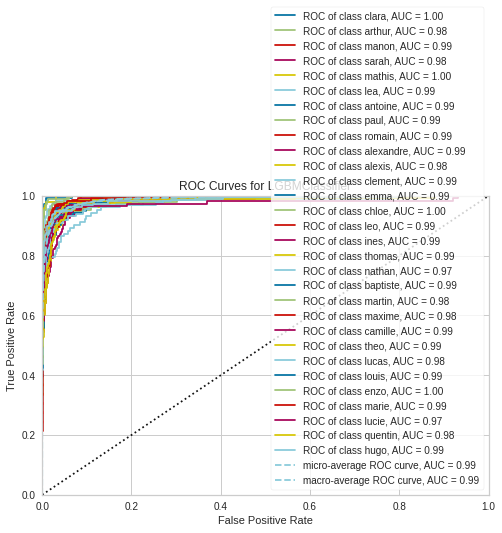

In [51]:
# Instaniate the classification model and visualizer
visualizer = ROCAUC(lgb_model, classes=list(set(y_test)))

visualizer.fit(X_train2, y_train2)    
visualizer.score(X_test, y_test)
#visualizer.ax.legend(loc='center left', bbox_to_anchor=(10, 20))
visualizer.show()         

### Confusion Matrix

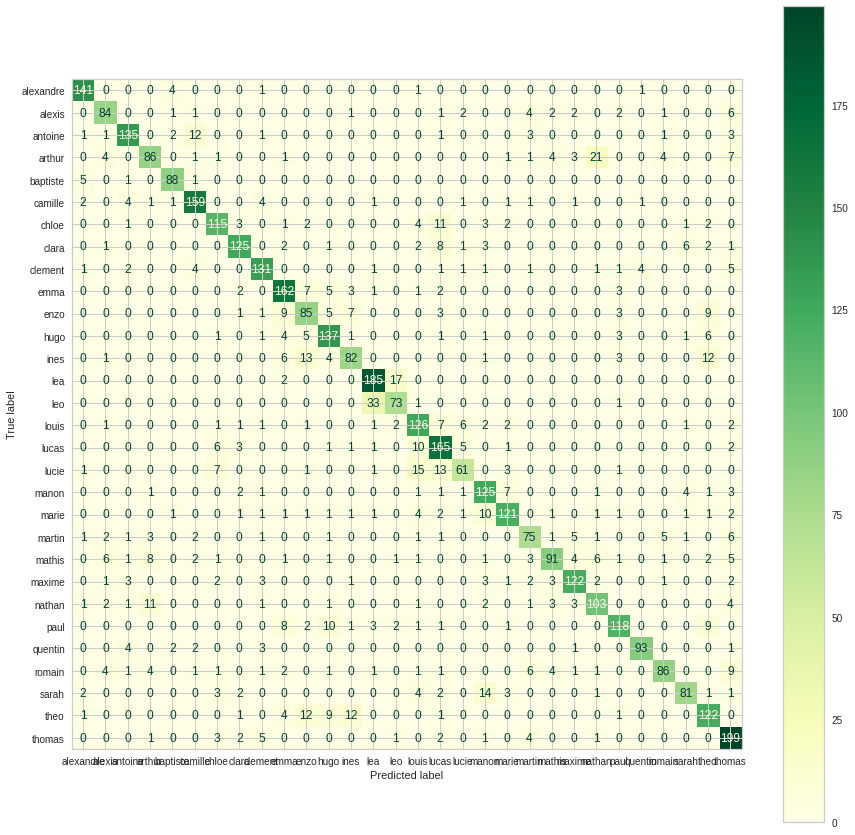

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
confusion = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,display_labels=lgb_model.classes_)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap = 'YlGn')

### Classification Report

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_test, target_names=lgb_model.classes_))

              precision    recall  f1-score   support

   alexandre       0.90      0.95      0.93       148
      alexis       0.79      0.79      0.79       107
     antoine       0.88      0.84      0.86       160
      arthur       0.75      0.64      0.69       134
    baptiste       0.89      0.93      0.91        95
     camille       0.86      0.90      0.88       177
       chloe       0.82      0.79      0.80       145
       clara       0.87      0.82      0.85       152
     clement       0.84      0.85      0.85       154
        emma       0.80      0.87      0.83       186
        enzo       0.66      0.69      0.67       123
        hugo       0.77      0.85      0.81       161
        ines       0.75      0.67      0.71       122
         lea       0.81      0.91      0.85       204
         leo       0.76      0.68      0.72       108
       louis       0.72      0.82      0.77       154
       lucas       0.74      0.85      0.79       195
       lucie       0.77    

In [54]:
print(classification_report(y_train2, pred_train, target_names=lgb_model.classes_))

              precision    recall  f1-score   support

   alexandre       1.00      1.00      1.00       709
      alexis       1.00      1.00      1.00       628
     antoine       1.00      1.00      1.00       796
      arthur       1.00      1.00      1.00       627
    baptiste       1.00      1.00      1.00       652
     camille       1.00      1.00      1.00       909
       chloe       1.00      1.00      1.00       842
       clara       1.00      1.00      1.00       785
     clement       1.00      1.00      1.00       891
        emma       1.00      1.00      1.00       999
        enzo       1.00      1.00      1.00       794
        hugo       1.00      1.00      1.00       910
        ines       1.00      1.00      1.00       611
         lea       1.00      1.00      1.00      1042
         leo       1.00      1.00      1.00       580
       louis       0.99      1.00      1.00       826
       lucas       1.00      1.00      1.00       987
       lucie       1.00    

### Visualization

In [74]:
np.array(X_train.iloc[432,:])

array([-1, -1, -1, ..., -1, -1, -1])

In [75]:
!pip install opendatasets
import opendatasets as od

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
od.download("https://www.kaggle.com/datasets/landlord/handwriting-recognition/download")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: xuetingggg
Your Kaggle Key: ··········


100%|██████████| 1.26G/1.26G [00:20<00:00, 65.6MB/s]


In [90]:
path = '/content/handwriting-recognition/validation_v2/validation/'

In [91]:
test_n_shape = pd.read_csv(filepath + 'test_n_shape.csv', index_col = 0)

In [92]:
test_n_shape.head()

,FILENAME,IDENTITY,height,width,dim,km_cluser
0,VALIDATION_0003.jpg,lea,31,284,3,1
1,VALIDATION_0016.jpg,antoine,31,284,3,1
2,VALIDATION_0022.jpg,mathis,44,324,3,2
3,VALIDATION_0032.jpg,hugo,30,388,3,0
4,VALIDATION_0039.jpg,clement,31,284,3,1


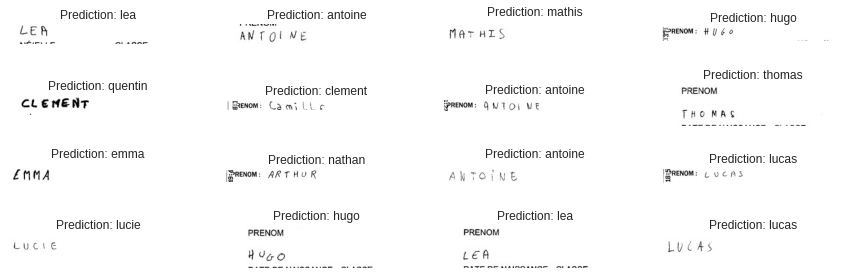

In [97]:
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    img_dir = path+test_n_shape.loc[i, 'FILENAME']
    img = cv2.imread(img_dir)
    #img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    title = f"Prediction: {pred_test[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()